# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies
import pandas as pd
import numpy as np
from citipy import citipy
from random import uniform
from scipy import stats as st
import matplotlib.pyplot as plt
import requests
import json
from pathlib import Path

# Import API keys
from api_keys import (weather_api_key, g_key)

## Function Block

In [2]:
def randLatLong():
    Lat = uniform(-90,90)
    Lng = uniform(-180,180)
    return Lat, Lng

## Generate Cities List

In [3]:
numCities = 750
cityList = []
for x in range(numCities):
    cityList.append(randLatLong())

cityName = []
cityCountry = []
for city in cityList:
    lat = city[0]
    lng = city[1]
    city = citipy.nearest_city(lat, lng)
    cityName.append(city.city_name)
    cityCountry.append(city.country_code)
city_df = pd.DataFrame(data = cityList)
city_df['CityName'] = cityName
city_df['CountryCode'] = cityCountry
city_df.columns = ['Lat Guess', 'Long Guess', 'CityName','CountryCode']
city_df['Temperature'] = ''
city_df['Humidity'] = ''
city_df['Cloudiness'] = ''
city_df['Wind Speed'] = ''
city_df['Lat Real'] = ''
city_df['Long Real'] = ''
city_df.head()

,Lat Guess,Long Guess,CityName,CountryCode,Temperature,Humidity,Cloudiness,Wind Speed,Lat Real,Long Real
0,-59.750558,98.501929,busselton,au,,,,,,
1,-75.446240,-56.957897,ushuaia,ar,,,,,,
2,-35.554173,-122.537342,rikitea,pf,,,,,,
3,44.481512,142.016305,nayoro,jp,,,,,,
4,-51.126258,21.364311,bredasdorp,za,,,,,,


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

In [5]:
# Outputting sample query to be able to look at json format
qry = query_url + city_df['CityName'][0] + ',' + city_df['CountryCode'][0]
print(qry)

http://api.openweathermap.org/data/2.5/weather?appid=30f405648767c0f1706e75e615852de5&units=imperial&q=busselton,au


In [6]:
lat = []
lon = []
temp = []
hum = []
cloud = []
wind = []
for index,row in city_df.iterrows():
    print(f'Working on City Number {index}: {row[2]}, {row[3]}')
    try:
        response = requests.get(query_url + row[2] + ',' + row[3]).json()
        city_df['Lat Real'][index] = response['coord']['lat']
        city_df['Long Real'][index] = response['coord']['lon']
        city_df['Temperature'][index] = response['main']['temp_max']
        city_df['Humidity'][index] = response['main']['humidity']
        city_df['Cloudiness'][index] = response['clouds']['all']
        city_df['Wind Speed'][index] = response['wind']['speed']
    except:
        city_df['Lat Real'][index] = np.nan
        city_df['Long Real'][index] = np.nan
        city_df['Temperature'][index] = np.nan
        city_df['Humidity'][index] = np.nan
        city_df['Cloudiness'][index] = np.nan
        city_df['Wind Speed'][index] = np.nan  
        print('')
        print(f'City Number is missing data')
        print('')

Working on City Number 0: busselton, au
Working on City Number 1: ushuaia, ar
Working on City Number 2: rikitea, pf


<ipython-input-6-cbf8250bdb39>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['Lat Real'][index] = response['coord']['lat']
<ipython-input-6-cbf8250bdb39>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['Long Real'][index] = response['coord']['lon']
<ipython-input-6-cbf8250bdb39>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['Temperature'][index] = response['main']['temp_max']
<ipython-input-6-cbf8250bd

Working on City Number 3: nayoro, jp
Working on City Number 4: bredasdorp, za
Working on City Number 5: yarmouth, ca
Working on City Number 6: nikolskoye, ru
Working on City Number 7: yellowknife, ca
Working on City Number 8: castro, cl
Working on City Number 9: necochea, ar
Working on City Number 10: ambilobe, mg
Working on City Number 11: new norfolk, au
Working on City Number 12: kleck, by

City Number is missing data

Working on City Number 13: kapaa, us


<ipython-input-6-cbf8250bdb39>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['Lat Real'][index] = np.nan
<ipython-input-6-cbf8250bdb39>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['Long Real'][index] = np.nan
<ipython-input-6-cbf8250bdb39>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['Temperature'][index] = np.nan
<ipython-input-6-cbf8250bdb39>:21: SettingWithCopyWarning: 
A value is trying to be 

Working on City Number 14: port alfred, za
Working on City Number 15: hilo, us
Working on City Number 16: ushuaia, ar
Working on City Number 17: mataura, pf

City Number is missing data

Working on City Number 18: nizhneyansk, ru

City Number is missing data

Working on City Number 19: avarua, ck
Working on City Number 20: asau, tv

City Number is missing data

Working on City Number 21: mataura, pf

City Number is missing data

Working on City Number 22: jamestown, sh
Working on City Number 23: melo, uy
Working on City Number 24: dikson, ru
Working on City Number 25: vaini, to
Working on City Number 26: hobart, au
Working on City Number 27: inirida, co
Working on City Number 28: barrow, us
Working on City Number 29: ribeira grande, pt
Working on City Number 30: barentu, er
Working on City Number 31: rikitea, pf
Working on City Number 32: general roca, ar
Working on City Number 33: sokol, ru
Working on City Number 34: rafaela, ar
Working on City Number 35: lagoa, pt
Working on City Num

Working on City Number 201: cidreira, br
Working on City Number 202: dikson, ru
Working on City Number 203: tuatapere, nz
Working on City Number 204: ponta do sol, cv
Working on City Number 205: castro, cl
Working on City Number 206: upernavik, gl
Working on City Number 207: dunda, tz
Working on City Number 208: gazanjyk, tm
Working on City Number 209: hermanus, za
Working on City Number 210: chimore, bo
Working on City Number 211: klaksvik, fo
Working on City Number 212: qaanaaq, gl
Working on City Number 213: rikitea, pf
Working on City Number 214: hilo, us
Working on City Number 215: ushuaia, ar
Working on City Number 216: jamestown, sh
Working on City Number 217: soddy-daisy, us
Working on City Number 218: simoes, br
Working on City Number 219: nikolskoye, ru
Working on City Number 220: mataura, pf

City Number is missing data

Working on City Number 221: tautira, pf
Working on City Number 222: albany, au
Working on City Number 223: rikitea, pf
Working on City Number 224: khandyga,

Working on City Number 385: puerto ayora, ec
Working on City Number 386: illoqqortoormiut, gl

City Number is missing data

Working on City Number 387: carmarthen, gb
Working on City Number 388: cayenne, gf
Working on City Number 389: andenes, no
Working on City Number 390: upernavik, gl
Working on City Number 391: klaksvik, fo
Working on City Number 392: barrow, us
Working on City Number 393: bathsheba, bb
Working on City Number 394: busselton, au
Working on City Number 395: carnarvon, au
Working on City Number 396: pafos, cy
Working on City Number 397: maldonado, uy
Working on City Number 398: mar del plata, ar
Working on City Number 399: pisco, pe
Working on City Number 400: alice springs, au
Working on City Number 401: punta arenas, cl
Working on City Number 402: busselton, au
Working on City Number 403: busselton, au
Working on City Number 404: iqaluit, ca
Working on City Number 405: caravelas, br
Working on City Number 406: talnakh, ru
Working on City Number 407: hithadhoo, mv
Wo

Working on City Number 568: mataura, pf

City Number is missing data

Working on City Number 569: kapaa, us
Working on City Number 570: paamiut, gl
Working on City Number 571: norman wells, ca
Working on City Number 572: jamestown, sh
Working on City Number 573: saint george, bm
Working on City Number 574: ulladulla, au
Working on City Number 575: bajil, ye
Working on City Number 576: makakilo city, us
Working on City Number 577: maceio, br
Working on City Number 578: lebu, cl
Working on City Number 579: karratha, au
Working on City Number 580: belushya guba, ru

City Number is missing data

Working on City Number 581: caohai, cn
Working on City Number 582: ushuaia, ar
Working on City Number 583: ostrovnoy, ru
Working on City Number 584: chuy, uy
Working on City Number 585: bengkulu, id
Working on City Number 586: barentsburg, sj

City Number is missing data

Working on City Number 587: grindavik, is
Working on City Number 588: vaini, to
Working on City Number 589: cayenne, gf
Working 

In [7]:
cols = ['Temperature', 'Humidity', 'Cloudiness', 'Wind Speed', 'Lat Real', 'Long Real']
city_df[cols].replace('', 0, inplace=True)
city_df.dropna(how='any', inplace=True)
city_df.head(100)

C:\Users\Cam Foster\anaconda3\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Lat Guess,Long Guess,CityName,CountryCode,Temperature,Humidity,Cloudiness,Wind Speed,Lat Real,Long Real
0,-59.750558,98.501929,busselton,au,54,97,22,7.92,-33.65,115.33
1,-75.446240,-56.957897,ushuaia,ar,48.2,39,40,14.99,-54.8,-68.3
2,-35.554173,-122.537342,rikitea,pf,75.33,84,100,17.27,-23.12,-134.97
3,44.481512,142.016305,nayoro,jp,39.4,86,100,3.31,44.35,142.46
4,-51.126258,21.364311,bredasdorp,za,62.6,82,100,2.24,-34.53,20.04
...,...,...,...,...,...,...,...,...,...,...
110,-39.619801,-69.345897,neuquen,ar,69.8,15,0,13.87,-38.95,-68.06
111,63.465776,-145.449210,fairbanks,us,30,100,90,6.91,64.84,-147.72
112,7.183434,71.951407,dhidhdhoo,mv,82.17,77,69,7.07,6.88,73.1
113,10.697399,91.290525,port blair,in,79.45,77,57,3.53,11.67,92.75


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [8]:
city_df[cols] = city_df[cols].astype(float)
city_df.describe()

,Lat Guess,Long Guess,Temperature,Humidity,Cloudiness,Wind Speed,Lat Real,Long Real
count,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000
mean,1.163692,1.470756,56.592252,75.504505,57.439940,9.486156,7.174414,2.155120
std,51.098499,101.774745,22.152505,18.209660,38.053348,6.015142,40.969887,100.654044
min,-89.985153,-178.853259,-11.740000,12.000000,0.000000,0.540000,-54.800000,-179.170000
25%,-42.645163,-78.628412,47.292500,68.000000,20.500000,4.700000,-33.590000,-71.332500
50%,0.079245,-7.257370,59.000000,79.500000,75.000000,8.050000,-0.740000,-5.720000
75%,44.593777,91.934417,75.330000,88.000000,93.000000,13.967500,47.160000,102.145000
max,89.084851,179.828250,95.000000,100.000000,100.000000,33.330000,78.220000,178.420000


In [25]:
printpath = Path.cwd() / 'cities.csv'
city_df.to_csv(printpath)

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [281]:
#  Get the indices of cities that have humidity over 100%.


In [282]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

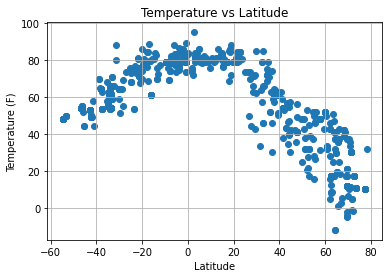

In [9]:
scat1 = plt.scatter(city_df['Lat Real'], city_df['Temperature'])
scat1 = plt.xlabel('Latitude')
scat1 = plt.ylabel('Temperature (F)')
scat1 = plt.title("Temperature vs Latitude")
scat1 = plt.grid(True)
plt.savefig("Temperature Vs Latitude.png")

## Latitude vs. Humidity Plot

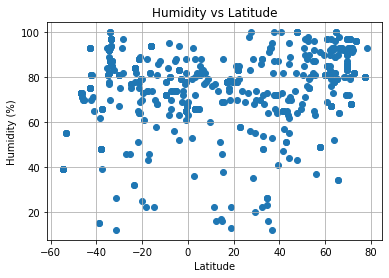

In [10]:
scat2 = plt.scatter(city_df['Lat Real'], city_df['Humidity'])
scat2 = plt.xlabel('Latitude')
scat2 = plt.ylabel('Humidity (%)')
scat2 = plt.title("Humidity vs Latitude")
scat2 = plt.grid(True)
plt.savefig("Humidity Vs Latitude.png")

## Latitude vs. Cloudiness Plot

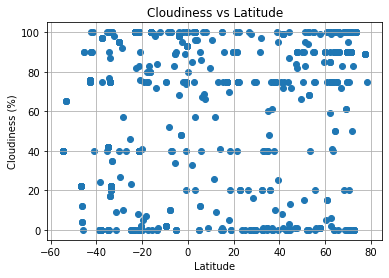

In [11]:
scat3 = plt.scatter(city_df['Lat Real'], city_df['Cloudiness'])
scat3 = plt.xlabel('Latitude')
scat3 = plt.ylabel('Cloudiness (%)')
scat3 = plt.title("Cloudiness vs Latitude")
scat3 = plt.grid(True)
plt.savefig("Cloudiness Vs Latitude.png")

## Latitude vs. Wind Speed Plot

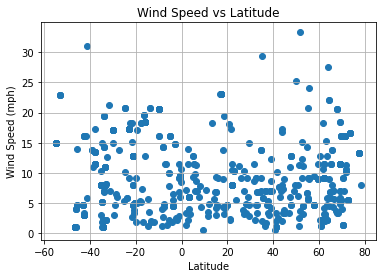

In [12]:
scat4 = plt.scatter(city_df['Lat Real'], city_df['Wind Speed'])
scat4 = plt.xlabel('Latitude')
scat4 = plt.ylabel('Wind Speed (mph)')
scat4 = plt.title("Wind Speed vs Latitude")
scat4 = plt.grid(True)
plt.savefig("Wind Speed Vs Latitude.png")

## Linear Regression

In [13]:
northCities = city_df.loc[city_df['Lat Real'] > 0]
southCities = city_df.loc[city_df['Lat Real'] < 0]

In [14]:
northCities.describe()

,Lat Guess,Long Guess,Temperature,Humidity,Cloudiness,Wind Speed,Lat Real,Long Real
count,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000
mean,47.328633,-3.290167,46.943218,75.394322,59.293375,8.835773,45.292271,-3.971514
std,25.457425,104.901415,26.586908,18.493046,38.903878,5.788092,22.327419,99.135512
min,-4.119813,-178.717909,-11.740000,12.000000,0.000000,0.540000,1.740000,-179.170000
25%,25.736952,-93.678212,24.800000,68.000000,15.000000,4.700000,26.870000,-80.180000
50%,46.740822,-6.473912,46.000000,80.000000,75.000000,7.610000,49.280000,-6.590000
75%,69.582796,86.656107,74.010000,88.000000,90.000000,11.410000,65.280000,80.550000
max,89.084851,178.659191,95.000000,100.000000,100.000000,33.330000,78.220000,178.420000


In [15]:
southCities.describe()

,Lat Guess,Long Guess,Temperature,Humidity,Cloudiness,Wind Speed,Lat Real,Long Real
count,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000
mean,-40.768361,5.795148,65.356562,75.604585,55.756447,10.076905,-27.448395,7.720000
std,26.388052,98.801190,11.577716,17.974394,37.239914,6.163123,15.137447,101.836092
min,-89.985153,-178.853259,44.600000,12.000000,0.000000,1.010000,-54.800000,-175.200000
25%,-62.357196,-70.884323,54.000000,68.000000,22.000000,4.700000,-35.020000,-68.300000
50%,-39.851422,-8.696895,64.400000,79.000000,48.000000,9.170000,-33.010000,-5.720000
75%,-18.776043,95.149894,75.330000,88.000000,97.000000,14.990000,-16.480000,115.330000
max,11.879445,179.828250,88.930000,100.000000,100.000000,31.090000,-0.160000,175.520000


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is 0.8021


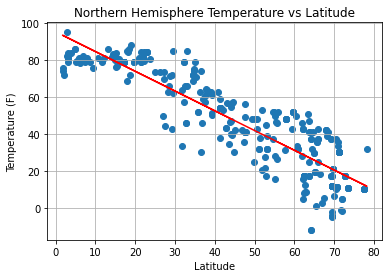

In [16]:
slope, intercept, rvalue, pvalue, stderr = st.linregress(northCities['Lat Real'], northCities['Temperature'])
print(f'The r-value is {rvalue**2:0.4f}')
scat5 = plt.scatter(northCities['Lat Real'], northCities['Temperature'])
scat5 = plt.xlabel('Latitude')
scat5 = plt.ylabel('Temperature (F)')
scat5 = plt.title("Northern Hemisphere Temperature vs Latitude")
scat5 = plt.grid(True)
lineq5 = slope * northCities['Lat Real'] + intercept
plt.plot(northCities['Lat Real'], lineq5, color='red')
plt.savefig("Northern Hemisphere Temperature Vs Latitude.png")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is 0.8612


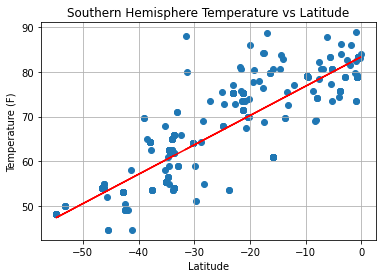

In [18]:
slope, intercept, rvalue, pvalue, stderr = st.linregress(southCities['Lat Real'], southCities['Temperature'])
print(f'The r-value is {rvalue:0.4f}')
scat6 = plt.scatter(southCities['Lat Real'], southCities['Temperature'])
scat6 = plt.xlabel('Latitude')
scat6 = plt.ylabel('Temperature (F)')
scat6 = plt.title("Southern Hemisphere Temperature vs Latitude")
scat6 = plt.grid(True)
lineq6 = slope * southCities['Lat Real'] + intercept
plt.plot(southCities['Lat Real'], lineq6, color='red')
plt.savefig("Southern Hemisphere Temperature Vs Latitude.png")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is 0.3250


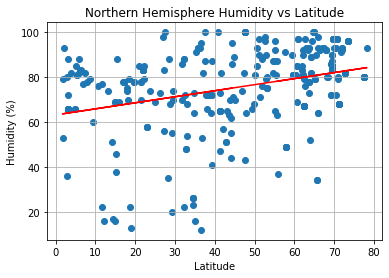

In [19]:
slope, intercept, rvalue, pvalue, stderr = st.linregress(northCities['Lat Real'], northCities['Humidity'])
print(f'The r-value is {rvalue:0.4f}')
scat7 = plt.scatter(northCities['Lat Real'], northCities['Humidity'])
scat7 = plt.xlabel('Latitude')
scat7 = plt.ylabel('Humidity (%)')
scat7 = plt.title("Northern Hemisphere Humidity vs Latitude")
scat7 = plt.grid(True)
lineq7 = slope * northCities['Lat Real'] + intercept
plt.plot(northCities['Lat Real'], lineq7, color='red')
plt.savefig("Northern Hemisphere Humidity Vs Latitude.png")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is 0.1798


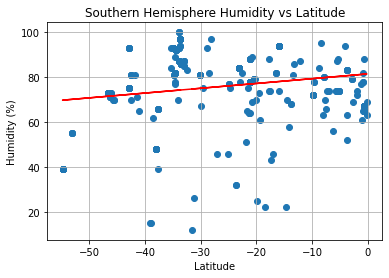

In [20]:
slope, intercept, rvalue, pvalue, stderr = st.linregress(southCities['Lat Real'], southCities['Humidity'])
print(f'The r-value is {rvalue:0.4f}')
scat8 = plt.scatter(southCities['Lat Real'], southCities['Humidity'])
scat8 = plt.xlabel('Latitude')
scat8 = plt.ylabel('Humidity (%)')
scat8 = plt.title("Southern Hemisphere Humidity vs Latitude")
scat8 = plt.grid(True)
lineq8 = slope * southCities['Lat Real'] + intercept
plt.plot(southCities['Lat Real'], lineq8, color='red')
plt.savefig("Southern Hemisphere Humidity Vs Latitude.png")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is 0.1351


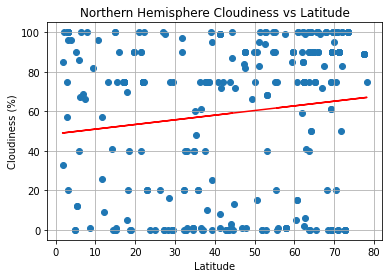

In [21]:
slope, intercept, rvalue, pvalue, stderr = st.linregress(northCities['Lat Real'], northCities['Cloudiness'])
print(f'The r-value is {rvalue:0.4f}')
scat9 = plt.scatter(northCities['Lat Real'], northCities['Cloudiness'])
scat9 = plt.xlabel('Latitude')
scat9 = plt.ylabel('Cloudiness (%)')
scat9 = plt.title("Northern Hemisphere Cloudiness vs Latitude")
scat9 = plt.grid(True)
lineq9 = slope * northCities['Lat Real'] + intercept
plt.plot(northCities['Lat Real'], lineq9, color='red')
plt.savefig("Northern Hemisphere Cloudiness Vs Latitude.png")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is 0.2080


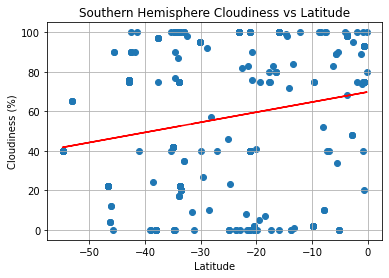

In [22]:
slope, intercept, rvalue, pvalue, stderr = st.linregress(southCities['Lat Real'], southCities['Cloudiness'])
print(f'The r-value is {rvalue:0.4f}')
scat10 = plt.scatter(southCities['Lat Real'], southCities['Cloudiness'])
scat10 = plt.xlabel('Latitude')
scat10 = plt.ylabel('Cloudiness (%)')
scat10 = plt.title("Southern Hemisphere Cloudiness vs Latitude")
scat10 = plt.grid(True)
lineq10 = slope * southCities['Lat Real'] + intercept
plt.plot(southCities['Lat Real'], lineq10, color='red')
plt.savefig("Southern Hemisphere Cloudiness Vs Latitude.png")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is 0.1092


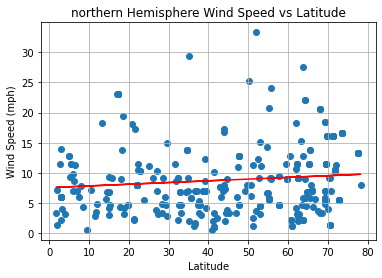

In [23]:
slope, intercept, rvalue, pvalue, stderr = st.linregress(northCities['Lat Real'], northCities['Wind Speed'])
print(f'The r-value is {rvalue:0.4f}')
scat11 = plt.scatter(northCities['Lat Real'], northCities['Wind Speed'])
scat11 = plt.xlabel('Latitude')
scat11 = plt.ylabel('Wind Speed (mph)')
scat11 = plt.title("northern Hemisphere Wind Speed vs Latitude")
scat11 = plt.grid(True)
lineq11 = slope * northCities['Lat Real'] + intercept
plt.plot(northCities['Lat Real'], lineq11, color='red')
plt.savefig("Northern Hemisphere Wind Speed Vs Latitude.png")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is 0.0331


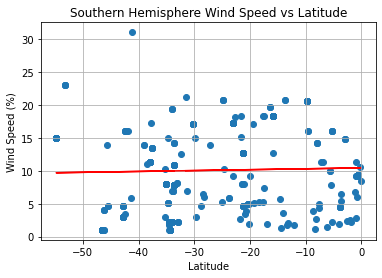

In [24]:
slope, intercept, rvalue, pvalue, stderr = st.linregress(southCities['Lat Real'], southCities['Wind Speed'])
print(f'The r-value is {rvalue:0.4f}')
scat9 = plt.scatter(southCities['Lat Real'], southCities['Wind Speed'])
scat9 = plt.xlabel('Latitude')
scat9 = plt.ylabel('Wind Speed (%)')
scat9 = plt.title("Southern Hemisphere Wind Speed vs Latitude")
scat9 = plt.grid(True)
lineq9 = slope * southCities['Lat Real'] + intercept
plt.plot(southCities['Lat Real'], lineq9, color='red')
plt.savefig("Southern Hemisphere Wind Speed Vs Latitude.png")